In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product h.csv', parse_dates=['Month-Year'])


In [3]:
sales_h= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_h = sales_h.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_h.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,62686,142038,447509
1,2019-02-01,74426,168635,531319
2,2019-03-01,91347,206976,652116
3,2019-04-01,60600,137309,432617
4,2019-05-01,37374,84683,266809


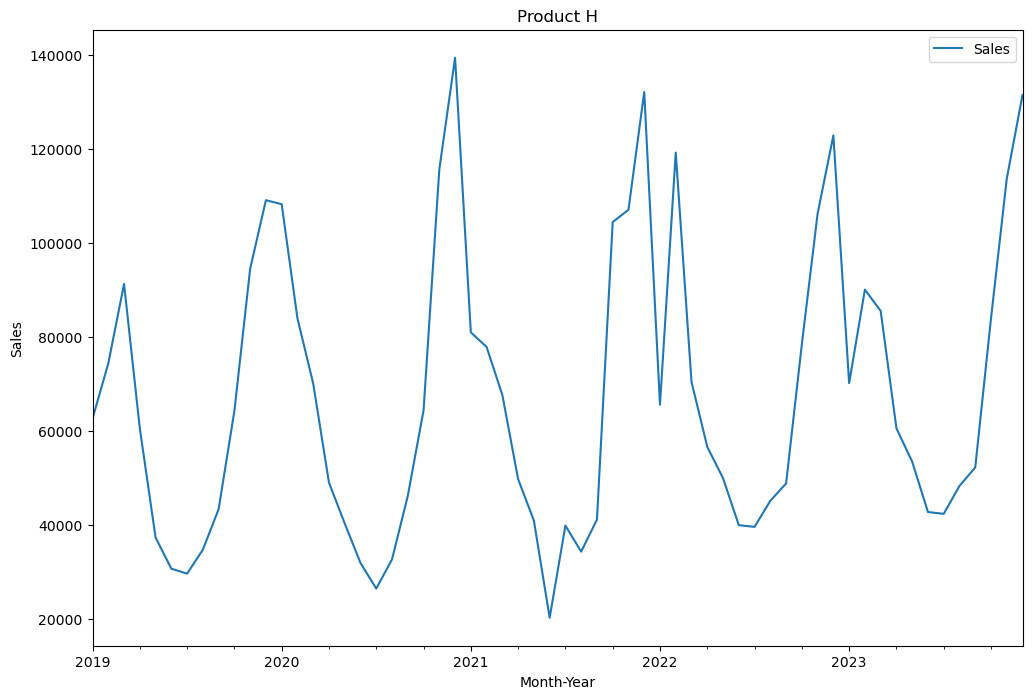

In [5]:
ax = sales_h.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product H')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_h[:57]
test=sales_h[57:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

12:12:48 - cmdstanpy - INFO - Chain [1] start processing
12:12:48 - cmdstanpy - INFO - Chain [1] done processing
12:12:59 - cmdstanpy - INFO - Chain [1] start processing
12:13:07 - cmdstanpy - INFO - Chain [1] done processing
12:13:12 - cmdstanpy - INFO - Chain [1] start processing
12:13:12 - cmdstanpy - INFO - Chain [1] done processing
12:13:23 - cmdstanpy - INFO - Chain [1] start processing
12:13:23 - cmdstanpy - INFO - Chain [1] done processing
12:13:35 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing
12:13:40 - cmdstanpy - INFO - Chain [1] start processing
12:13:40 - cmdstanpy - INFO - Chain [1] done processing
12:13:45 - cmdstanpy - INFO - Chain [1] start processing
12:13:46 - cmdstanpy - INFO - Chain [1] done processing
12:13:50 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:57 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   13316.057590  
1   14968.461806  
2   13147.044011  
3   12321.292981  
4   14045.125078  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
62,0.500,0.1,additive,11563.469931
27,0.100,0.1,multiplicative,12048.555152
39,0.200,0.1,multiplicative,12131.376013
3,0.001,0.1,multiplicative,12321.292981
15,0.010,0.1,multiplicative,12345.665915
...,...,...,...,...
28,0.100,1.0,additive,15127.438148
71,0.500,10.0,multiplicative,15327.487887
67,0.500,3.0,multiplicative,15346.709889
66,0.500,3.0,additive,15401.328614


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.500, seasonality_prior_scale=0.1, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:37 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

3

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_h['Market Size']
future_dates['Marketing Expense'] = sales_h['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,142038,447509
1,2019-02-01,168635,531319
2,2019-03-01,206976,652116
3,2019-04-01,137309,432617
4,2019-05-01,84683,266809
5,2019-06-01,69648,219428
6,2019-07-01,67255,211904
7,2019-08-01,78824,248348
8,2019-09-01,98356,309885
9,2019-10-01,214290,675154


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,81610.464070,68116.697358,94854.507785
58,2023-11-01,106549.296685,91566.087945,118680.585518
59,2023-12-01,130944.120274,117959.274831,144463.652600


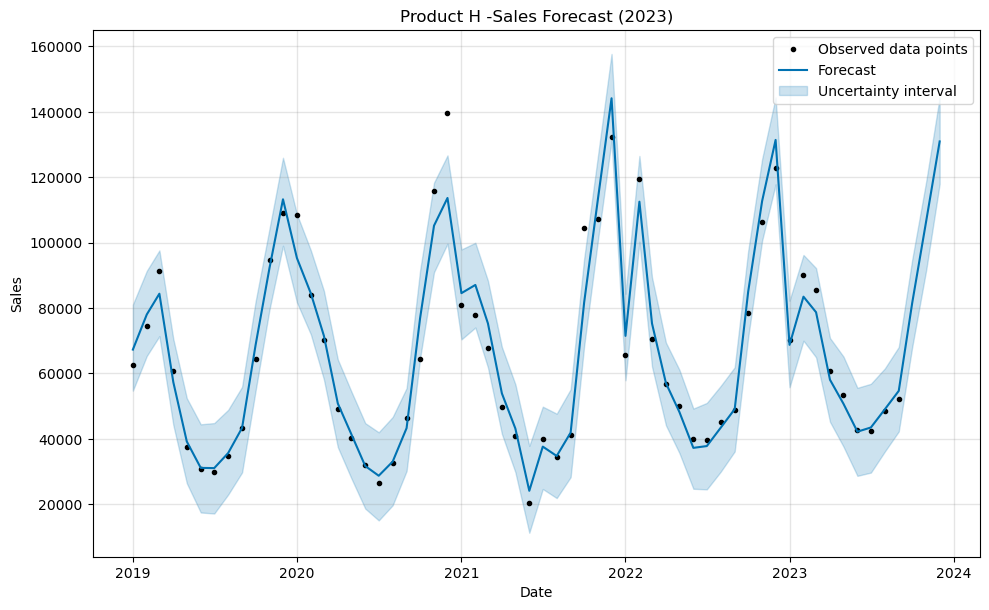

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product H -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

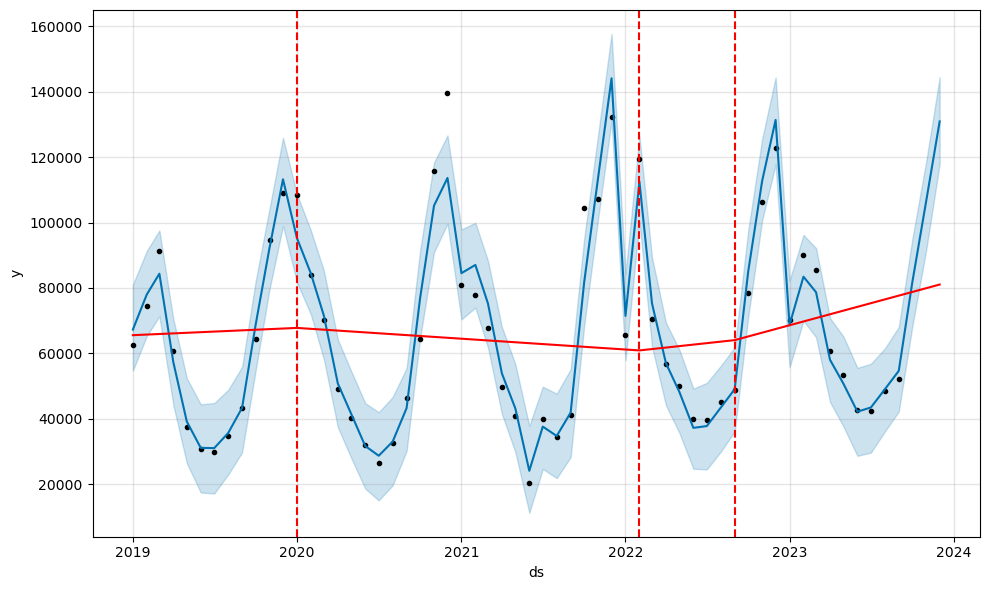

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

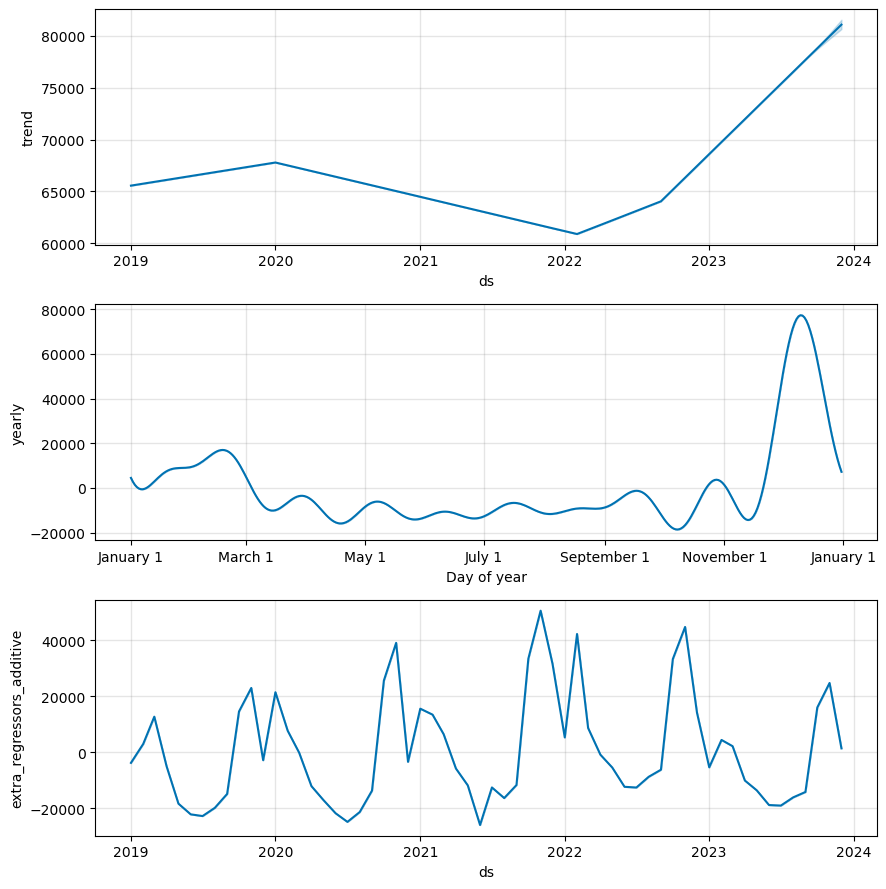

In [21]:
fig2 = model.plot_components(forecast)

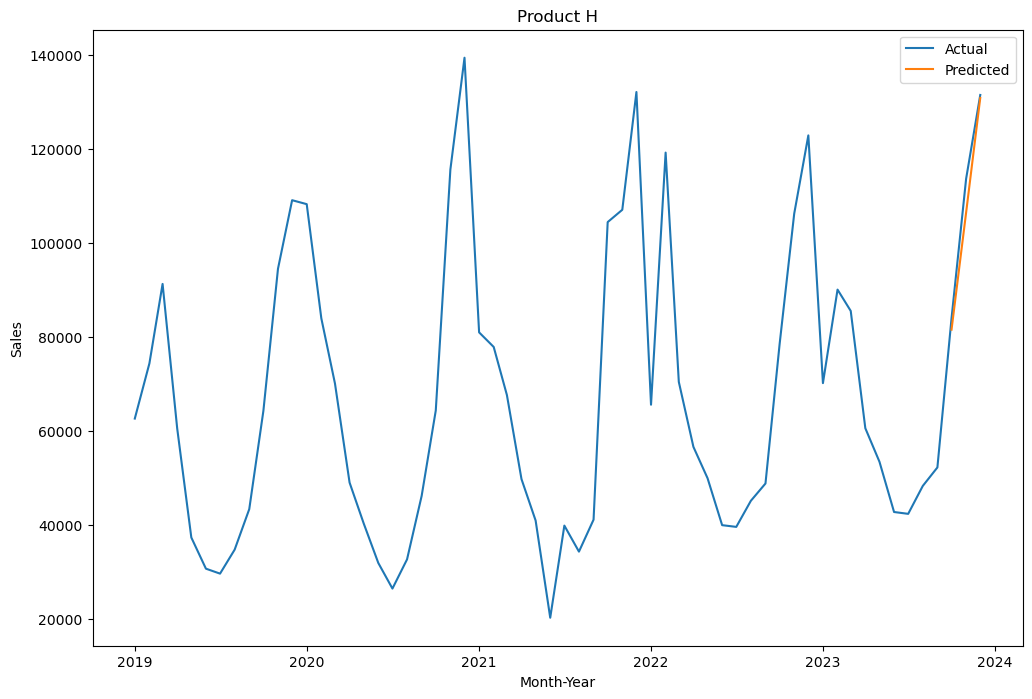

In [22]:
# Reset index of sales_b DataFrame
sales_h_reset_index = sales_h.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_h_reset_index['ds'], sales_h_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product H')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 3409.373
MAPE - FB PROPHET: 0.032
MSE - FB PROPHET: 19305291.616
RMSE - FB PROPHET: 4393.779


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,4.400125e+08,20976.475013,14639.956968,0.176997,0.130145,0.204252,0.666667
1,22 days,4.383980e+08,20937.955781,14267.492097,0.153876,0.092541,0.178922,0.666667
2,23 days,1.924228e+07,4386.601772,4060.867603,0.083489,0.092541,0.087973,1.000000
3,25 days,4.829294e+07,6949.312333,6273.673705,0.106663,0.128855,0.107854,1.000000
4,27 days,1.161616e+08,10777.827982,10090.447766,0.142689,0.128855,0.149666,0.666667
5,28 days,8.458394e+07,9196.952507,7639.132436,0.121463,0.089690,0.130354,0.666667
6,47 days,6.069554e+07,7790.734462,6669.812471,0.129899,0.089690,0.139590,0.500000
7,49 days,2.460483e+07,4960.325460,4592.573954,0.117325,0.111884,0.124437,0.666667
8,51 days,3.470824e+07,5891.370295,5724.694090,0.114767,0.111884,0.122029,0.666667
9,52 days,4.289481e+07,6549.413174,6240.100636,0.114562,0.111884,0.121783,1.000000


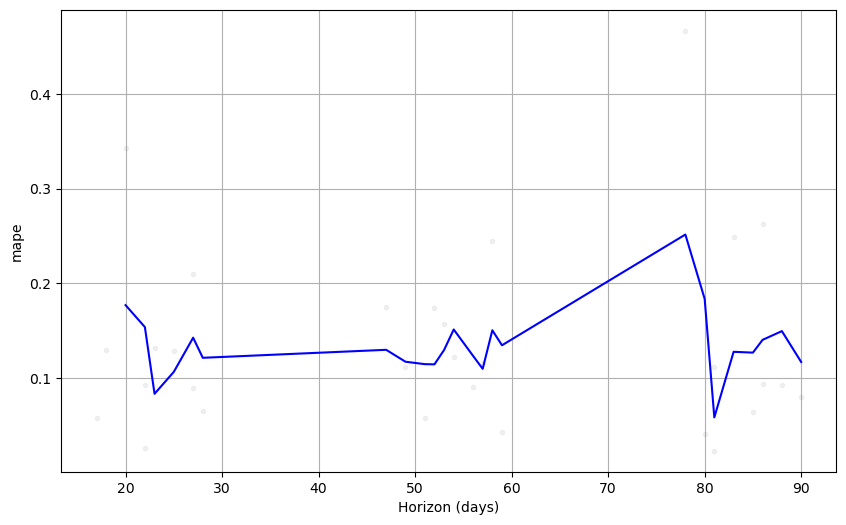

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
print(test_df)

57     84019
58    113741
59    131572
Name: y, dtype: int64


In [30]:
print(pred)

57     81610.464070
58    106549.296685
59    130944.120274
Name: yhat, dtype: float64
